In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from einops import rearrange
import torch.nn.functional as F

class vgg19_finetune19(nn.Module):
    def __init__(self, num_emotions) -> None:
        super().__init__()
        
        self.model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True)
        self.model_ft = nn.Sequential(*(list(self.model_ft.children())[:-1]))
        
        for name, param in self.model_ft[0][:10].named_parameters():
            param.requires_grad=False
        
        
        self.fc_linear1 = nn.Linear(25088, 4096)
        self.fc_linear2 = nn.Linear(4096, 8)
        
        
        self.softmax_out = nn.Softmax(dim=1)
    
    def forward(self, x):
        
        output = self.model_ft(x)
        output = torch.flatten(output, start_dim=1)
        output = self.fc_linear1(output)
        output_logits = self.fc_linear2(output)
        output_softmax = self.softmax_out(output_logits)
        
        return output_logits, output_softmax

In [2]:
import os
import torch
import numpy as np
from torchinfo import summary
from tqdm.auto import tqdm

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

emotions_dict = {
    0: 'Neutral',
    1: 'Calm',
    2: 'Happy',
    3: 'Sad',
    4: 'Angry',
    5: 'Fear',
    6: 'Disgust',
    7: 'Surprise'
}

model = vgg19_finetune19(num_emotions=len(emotions_dict)).to('cuda')
sub_name = 'vgg19_finetune19'
data_name = 'RAVDESS'
EARLY_CNT = 500

minibatch = 32
num_epochs = 500
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, betas=(0.9, 0.999), eps=1e-08, weight_decay=0., amsgrad=True)

print(summary(model, input_size=(minibatch, 3, 224, 224)))

Using cache found in C:\Users\devLupin/.cache\torch\hub\pytorch_vision_v0.10.0


Layer (type:depth-idx)                   Output Shape              Param #
vgg19_finetune19                         [32, 8]                   --
├─Sequential: 1-1                        [32, 512, 7, 7]           --
│    └─Sequential: 2-1                   [32, 512, 7, 7]           --
│    │    └─Conv2d: 3-1                  [32, 64, 224, 224]        (1,792)
│    │    └─ReLU: 3-2                    [32, 64, 224, 224]        --
│    │    └─Conv2d: 3-3                  [32, 64, 224, 224]        (36,928)
│    │    └─ReLU: 3-4                    [32, 64, 224, 224]        --
│    │    └─MaxPool2d: 3-5               [32, 64, 112, 112]        --
│    │    └─Conv2d: 3-6                  [32, 128, 112, 112]       (73,856)
│    │    └─ReLU: 3-7                    [32, 128, 112, 112]       --
│    │    └─Conv2d: 3-8                  [32, 128, 112, 112]       (147,584)
│    │    └─ReLU: 3-9                    [32, 128, 112, 112]       --
│    │    └─MaxPool2d: 3-10              [32, 128, 56, 56]   

In [3]:
def make_train_step(model, criterion, optimizer):

    # define the training step of the training phase
    def train_step(X, Y):

        # forward pass
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax, dim=1)
        accuracy = torch.sum(Y == predictions)/float(len(Y))

        # compute loss on logits because nn.CrossEntropyLoss implements log softmax
        loss = criterion(output_logits, Y)
        
        # compute gradients for the optimizer to use
        loss.backward()

        # update network parameters based on gradient stored (by calling loss.backward())
        optimizer.step()

        # zero out gradients for next pass
        # pytorch accumulates gradients from backwards passes (convenient for RNNs)
        optimizer.zero_grad()

        return loss.item(), accuracy*100
    return train_step

In [4]:
def make_validate_fnc(model, criterion):
    def validate(X, Y):

        # don't want to update any network parameters on validation passes: don't need gradient
        # wrap in torch.no_grad to save memory and compute in validation phase:
        with torch.no_grad():

            # set model to validation phase i.e. turn off dropout and batchnorm layers
            model.eval()
            
            # get the model's predictions on the validation set
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax, dim=1)

            # calculate the mean accuracy over the entire validation set
            accuracy = torch.sum(Y == predictions)/float(len(Y))

            # compute error from logits (nn.crossentropy implements softmax)
            loss = criterion(output_logits, Y)

        return loss.item(), accuracy*100, predictions
    return validate

In [5]:
def make_save_checkpoint():
    def save_checkpoint(optimizer, model, epoch, filename):
        checkpoint_dict = {
            'optimizer': optimizer.state_dict(),
            'model': model.state_dict(),
            'epoch': epoch
        }
        torch.save(checkpoint_dict, filename)
    return save_checkpoint


def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

In [6]:
from typing import Optional

def label_to_one_hot_label(
    labels: torch.Tensor,
    num_classes: int,
    device: Optional[torch.device] = None,
    dtype: Optional[torch.dtype] = None,
    eps: float = 1e-6,
    ignore_index=255,
) -> torch.Tensor:

    shape = labels.shape
    # one hot : (B, C=ignore_index+1, H, W)
    one_hot = torch.zeros((shape[0], ignore_index+1) + shape[1:], device=device, dtype=dtype)
    
    # labels : (B, H, W)
    # labels.unsqueeze(1) : (B, C=1, H, W)
    # one_hot : (B, C=ignore_index+1, H, W)
    one_hot = one_hot.scatter_(1, labels.unsqueeze(1), 1.0) + eps
    
    # ret : (B, C=num_classes, H, W)
    ret = torch.split(one_hot, [num_classes, ignore_index+1-num_classes], dim=1)[0]
    
    return ret


def focal_loss(input, target, alpha, gamma, reduction, eps, ignore_index):
    
    if not isinstance(input, torch.Tensor):
        raise TypeError(f"Input type is not a torch.Tensor. Got {type(input)}")

    if not len(input.shape) >= 2:
        raise ValueError(f"Invalid input shape, we expect BxCx*. Got: {input.shape}")

    if input.size(0) != target.size(0):
        raise ValueError(f'Expected input batch_size ({input.size(0)}) to match target batch_size ({target.size(0)}).')    
        
    # compute softmax over the classes axis
    # input_soft : (B, C, H, W)
    input_soft = F.softmax(input, dim=1) + eps
    
    # create the labels one hot tensor
    # target_one_hot : (B, C, H, W)
    target_one_hot = label_to_one_hot_label(target.long(), num_classes=input.shape[1], device=input.device, dtype=input.dtype, ignore_index=ignore_index)

    # compute the actual focal loss
    weight = torch.pow(1.0 - input_soft, gamma)
    
    # alpha, weight, input_soft : (B, C, H, W)
    # focal : (B, C, H, W)
    focal = -alpha * weight * torch.log(input_soft)
    
    # loss_tmp : (B, H, W)
    loss_tmp = torch.sum(target_one_hot * focal, dim=1)

    if reduction == 'none':
        # loss : (B, H, W)
        loss = loss_tmp
    elif reduction == 'mean':
        # loss : scalar
        loss = torch.mean(loss_tmp)
    elif reduction == 'sum':
        # loss : scalar
        loss = torch.sum(loss_tmp)
    else:
        raise NotImplementedError(f"Invalid reduction mode: {reduction}")
    return loss

class FocalLoss(nn.Module):
    def __init__(self, alpha, gamma = 2.0, reduction = 'mean', eps = 1e-8, ignore_index=30):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.eps = eps
        self.ignore_index = ignore_index

    def forward(self, input, target):
        return focal_loss(input, target, self.alpha, self.gamma, self.reduction, self.eps, self.ignore_index)


def criterion(predictions, targets):
    return FocalLoss(alpha=0.5, gamma=2.0, reduction='mean')(predictions, targets)

In [7]:
from einops import rearrange

def train(model, num_epochs, X_train, Y_train, X_valid, Y_valid, pkl_name, fold):
    
    # instantiate lists to hold scalar performance metrics to plot later
    train_losses = []
    valid_losses = []

    # get training set size to calculate # iterations and minibatch indices
    train_size = X_train.shape[0]

    # instantiate the checkpoint save function
    save_checkpoint = make_save_checkpoint()

    # instantiate the training step function
    train_step = make_train_step(model, criterion, optimizer=optimizer)
    # instantiate the validation loop function
    validate = make_validate_fnc(model, criterion)

    cur_valid_loss = 0x3f3f3f
    early_stop_cnt = 0
    
    for epoch in tqdm(range(num_epochs), desc=f'{fold}'):

        if early_stop_cnt >= EARLY_CNT:
            break
        
        # set model to train phase
        model.train()

        # shuffle entire training set in each epoch to randomize minibatch order
        train_indices = np.random.permutation(train_size)

        # shuffle the training set for each epoch:
        X_train = X_train[train_indices, :, :, :]
        Y_train = Y_train[train_indices]

        # instantiate scalar values to keep track of progress after each epoch so we can stop training when appropriate
        epoch_acc = 0
        epoch_loss = 0
        num_iterations = int(train_size / minibatch)

        # create a loop for each minibatch of 32 samples:
        for i in range(num_iterations):

            # we have to track and update minibatch position for the current minibatch
            # if we take a random batch position from a set, we almost certainly will skip some of the data in that set
            # track minibatch position based on iteration number:
            batch_start = i * minibatch
            # ensure we don't go out of the bounds of our training set:
            batch_end = min(batch_start + minibatch, train_size)
            # ensure we don't have an index error
            actual_batch_size = batch_end-batch_start

            # get training minibatch with all channnels and 2D feature dims
            X = X_train[batch_start:batch_end, :, :, :]
            # get training minibatch labels
            Y = Y_train[batch_start:batch_end]
            
            # instantiate training tensors
            X_tensor = torch.tensor(X, device=device).float()
            X_tensor = X_tensor.permute(0, 3, 1, 2)
            Y_tensor = torch.tensor(Y, dtype=torch.long, device=device)
            
            # Pass input tensors thru 1 training step (fwd+backwards pass)
            loss, acc = train_step(X_tensor, Y_tensor)

            # aggregate batch accuracy to measure progress of entire epoch
            epoch_acc += acc * actual_batch_size / train_size
            epoch_loss += loss * actual_batch_size / train_size

            # keep track of the iteration to see if the model's too slow
            print('\r'+f'Epoch {epoch}: iteration {i}/{num_iterations}', end='')

        X_valid_tensor = torch.tensor(X_valid, device=device).float()
        X_valid_tensor = X_valid_tensor.permute(0, 3, 1, 2)
        Y_valid_tensor = torch.tensor(Y_valid, dtype=torch.long, device=device)
        
        # calculate validation metrics to keep track of progress; don't need predictions now
        valid_loss, valid_acc, _ = validate(X_valid_tensor, Y_valid_tensor)
        
        # accumulate scalar performance metrics at each epoch to track and plot later
        train_losses.append(epoch_loss)
        valid_losses.append(valid_loss)
        
        if cur_valid_loss > valid_loss:
            save_checkpoint(optimizer, model, epoch, pkl_name)
            cur_valid_loss = valid_loss
        else:
            early_stop_cnt += 1

        # keep track of each epoch's progress
        print(f'\nEpoch {epoch} --- loss:{epoch_loss:.3f}, Validation loss:{valid_loss:.3f}')

        
    print(f"\n\n[*] done !")
    print(f'[*] Best training loss - {min(train_losses)}')
    print(f'[*] Best validation loss - {min(valid_losses)}')
    
    return train_losses, valid_losses

In [8]:
import csv
import numpy as np
from PIL import Image
from skimage.io import imread
from skimage.transform import resize

def get_fold_dataset(cur_fold_path):
    X_train, y_train, X_test, y_test = [], [], [], []
    
    train_f = open(os.path.join(cur_fold_path, 'train.csv'), 'r')
    test_f = open(os.path.join(cur_fold_path, 'test.csv'), 'r')
    
    train_reader = csv.reader(train_f)
    for r in train_reader:
        image = imread(r[0])
        image = resize(image, (224,224,3))
        X_train.append(image)
        y_train.append(int(r[1]))
        
    test_reader = csv.reader(test_f)
    for r in test_reader:
        image = imread(r[0])
        image = resize(image, (224,224,3))
        X_test.append(image)
        y_test.append(int(r[1]))
    
    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

[*] model training - vgg19_finetune19


0:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: iteration 34/35
Epoch 0 --- loss:0.756, Validation loss:0.737
Epoch 1: iteration 34/35
Epoch 1 --- loss:0.692, Validation loss:0.683
Epoch 2: iteration 34/35
Epoch 2 --- loss:0.614, Validation loss:0.614
Epoch 3: iteration 34/35
Epoch 3 --- loss:0.518, Validation loss:0.532
Epoch 4: iteration 34/35
Epoch 4 --- loss:0.418, Validation loss:0.475
Epoch 5: iteration 34/35
Epoch 5 --- loss:0.338, Validation loss:0.434
Epoch 6: iteration 34/35
Epoch 6 --- loss:0.272, Validation loss:0.423
Epoch 7: iteration 34/35
Epoch 7 --- loss:0.214, Validation loss:0.414
Epoch 8: iteration 34/35
Epoch 8 --- loss:0.164, Validation loss:0.403
Epoch 9: iteration 34/35
Epoch 9 --- loss:0.128, Validation loss:0.396
Epoch 10: iteration 34/35
Epoch 10 --- loss:0.100, Validation loss:0.412
Epoch 11: iteration 34/35
Epoch 11 --- loss:0.074, Validation loss:0.408
Epoch 12: iteration 34/35
Epoch 12 --- loss:0.058, Validation loss:0.415
Epoch 13: iteration 34/35
Epoch 13 --- loss:0.042, Validation loss:0.40

Epoch 112: iteration 34/35
Epoch 112 --- loss:0.000, Validation loss:0.598
Epoch 113: iteration 34/35
Epoch 113 --- loss:0.000, Validation loss:0.598
Epoch 114: iteration 34/35
Epoch 114 --- loss:0.000, Validation loss:0.598
Epoch 115: iteration 34/35
Epoch 115 --- loss:0.000, Validation loss:0.600
Epoch 116: iteration 34/35
Epoch 116 --- loss:0.000, Validation loss:0.599
Epoch 117: iteration 34/35
Epoch 117 --- loss:0.000, Validation loss:0.600
Epoch 118: iteration 34/35
Epoch 118 --- loss:0.000, Validation loss:0.601
Epoch 119: iteration 34/35
Epoch 119 --- loss:0.000, Validation loss:0.601
Epoch 120: iteration 34/35
Epoch 120 --- loss:0.000, Validation loss:0.602
Epoch 121: iteration 34/35
Epoch 121 --- loss:0.000, Validation loss:0.602
Epoch 122: iteration 34/35
Epoch 122 --- loss:0.000, Validation loss:0.602
Epoch 123: iteration 34/35
Epoch 123 --- loss:0.000, Validation loss:0.603
Epoch 124: iteration 34/35
Epoch 124 --- loss:0.000, Validation loss:0.604
Epoch 125: iteration 34/3

Epoch 221: iteration 34/35
Epoch 221 --- loss:0.000, Validation loss:0.633
Epoch 222: iteration 34/35
Epoch 222 --- loss:0.000, Validation loss:0.633
Epoch 223: iteration 34/35
Epoch 223 --- loss:0.000, Validation loss:0.634
Epoch 224: iteration 34/35
Epoch 224 --- loss:0.000, Validation loss:0.634
Epoch 225: iteration 34/35
Epoch 225 --- loss:0.000, Validation loss:0.634
Epoch 226: iteration 34/35
Epoch 226 --- loss:0.000, Validation loss:0.634
Epoch 227: iteration 34/35
Epoch 227 --- loss:0.000, Validation loss:0.634
Epoch 228: iteration 34/35
Epoch 228 --- loss:0.000, Validation loss:0.634
Epoch 229: iteration 34/35
Epoch 229 --- loss:0.000, Validation loss:0.635
Epoch 230: iteration 34/35
Epoch 230 --- loss:0.000, Validation loss:0.635
Epoch 231: iteration 34/35
Epoch 231 --- loss:0.000, Validation loss:0.635
Epoch 232: iteration 34/35
Epoch 232 --- loss:0.000, Validation loss:0.635
Epoch 233: iteration 34/35
Epoch 233 --- loss:0.000, Validation loss:0.635
Epoch 234: iteration 34/3

Epoch 330: iteration 34/35
Epoch 330 --- loss:0.000, Validation loss:0.651
Epoch 331: iteration 34/35
Epoch 331 --- loss:0.000, Validation loss:0.651
Epoch 332: iteration 34/35
Epoch 332 --- loss:0.000, Validation loss:0.651
Epoch 333: iteration 34/35
Epoch 333 --- loss:0.000, Validation loss:0.651
Epoch 334: iteration 34/35
Epoch 334 --- loss:0.000, Validation loss:0.651
Epoch 335: iteration 34/35
Epoch 335 --- loss:0.000, Validation loss:0.651
Epoch 336: iteration 34/35
Epoch 336 --- loss:0.000, Validation loss:0.651
Epoch 337: iteration 34/35
Epoch 337 --- loss:0.000, Validation loss:0.652
Epoch 338: iteration 34/35
Epoch 338 --- loss:0.000, Validation loss:0.651
Epoch 339: iteration 34/35
Epoch 339 --- loss:0.000, Validation loss:0.652
Epoch 340: iteration 34/35
Epoch 340 --- loss:0.000, Validation loss:0.652
Epoch 341: iteration 34/35
Epoch 341 --- loss:0.000, Validation loss:0.652
Epoch 342: iteration 34/35
Epoch 342 --- loss:0.000, Validation loss:0.652
Epoch 343: iteration 34/3

Epoch 439: iteration 34/35
Epoch 439 --- loss:0.000, Validation loss:0.661
Epoch 440: iteration 34/35
Epoch 440 --- loss:0.000, Validation loss:0.661
Epoch 441: iteration 34/35
Epoch 441 --- loss:0.000, Validation loss:0.661
Epoch 442: iteration 34/35
Epoch 442 --- loss:0.000, Validation loss:0.661
Epoch 443: iteration 34/35
Epoch 443 --- loss:0.000, Validation loss:0.661
Epoch 444: iteration 34/35
Epoch 444 --- loss:0.000, Validation loss:0.662
Epoch 445: iteration 34/35
Epoch 445 --- loss:0.000, Validation loss:0.662
Epoch 446: iteration 34/35
Epoch 446 --- loss:0.000, Validation loss:0.662
Epoch 447: iteration 34/35
Epoch 447 --- loss:0.000, Validation loss:0.662
Epoch 448: iteration 34/35
Epoch 448 --- loss:0.000, Validation loss:0.662
Epoch 449: iteration 34/35
Epoch 449 --- loss:0.000, Validation loss:0.662
Epoch 450: iteration 34/35
Epoch 450 --- loss:0.000, Validation loss:0.662
Epoch 451: iteration 34/35
Epoch 451 --- loss:0.000, Validation loss:0.662
Epoch 452: iteration 34/3

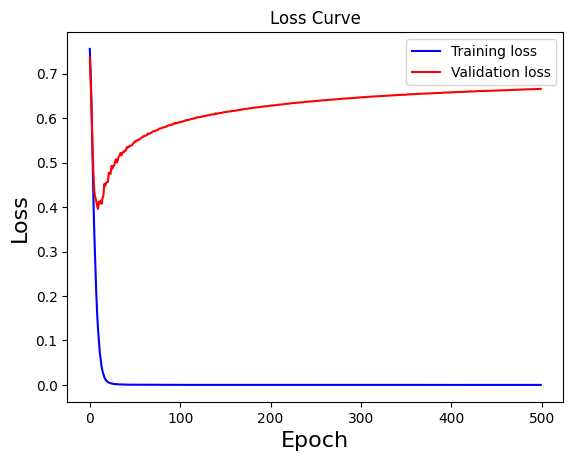

1:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: iteration 34/35
Epoch 0 --- loss:0.151, Validation loss:0.005
Epoch 1: iteration 34/35
Epoch 1 --- loss:0.039, Validation loss:0.010
Epoch 2: iteration 34/35
Epoch 2 --- loss:0.017, Validation loss:0.009
Epoch 3: iteration 34/35
Epoch 3 --- loss:0.007, Validation loss:0.009
Epoch 4: iteration 34/35
Epoch 4 --- loss:0.003, Validation loss:0.010
Epoch 5: iteration 34/35
Epoch 5 --- loss:0.002, Validation loss:0.010
Epoch 6: iteration 34/35
Epoch 6 --- loss:0.001, Validation loss:0.010
Epoch 7: iteration 34/35
Epoch 7 --- loss:0.001, Validation loss:0.010
Epoch 8: iteration 34/35
Epoch 8 --- loss:0.001, Validation loss:0.011
Epoch 9: iteration 34/35
Epoch 9 --- loss:0.001, Validation loss:0.010
Epoch 10: iteration 34/35
Epoch 10 --- loss:0.001, Validation loss:0.011
Epoch 11: iteration 34/35
Epoch 11 --- loss:0.001, Validation loss:0.011
Epoch 12: iteration 34/35
Epoch 12 --- loss:0.001, Validation loss:0.011
Epoch 13: iteration 34/35
Epoch 13 --- loss:0.000, Validation loss:0.01

Epoch 112: iteration 34/35
Epoch 112 --- loss:0.000, Validation loss:0.014
Epoch 113: iteration 34/35
Epoch 113 --- loss:0.000, Validation loss:0.014
Epoch 114: iteration 34/35
Epoch 114 --- loss:0.000, Validation loss:0.014
Epoch 115: iteration 34/35
Epoch 115 --- loss:0.000, Validation loss:0.014
Epoch 116: iteration 34/35
Epoch 116 --- loss:0.000, Validation loss:0.014
Epoch 117: iteration 34/35
Epoch 117 --- loss:0.000, Validation loss:0.014
Epoch 118: iteration 34/35
Epoch 118 --- loss:0.000, Validation loss:0.014
Epoch 119: iteration 34/35
Epoch 119 --- loss:0.000, Validation loss:0.014
Epoch 120: iteration 34/35
Epoch 120 --- loss:0.000, Validation loss:0.014
Epoch 121: iteration 34/35
Epoch 121 --- loss:0.000, Validation loss:0.014
Epoch 122: iteration 34/35
Epoch 122 --- loss:0.000, Validation loss:0.014
Epoch 123: iteration 34/35
Epoch 123 --- loss:0.000, Validation loss:0.014
Epoch 124: iteration 34/35
Epoch 124 --- loss:0.000, Validation loss:0.014
Epoch 125: iteration 34/3

Epoch 221: iteration 34/35
Epoch 221 --- loss:0.000, Validation loss:0.015
Epoch 222: iteration 34/35
Epoch 222 --- loss:0.000, Validation loss:0.015
Epoch 223: iteration 34/35
Epoch 223 --- loss:0.000, Validation loss:0.015
Epoch 224: iteration 34/35
Epoch 224 --- loss:0.000, Validation loss:0.015
Epoch 225: iteration 34/35
Epoch 225 --- loss:0.000, Validation loss:0.015
Epoch 226: iteration 34/35
Epoch 226 --- loss:0.000, Validation loss:0.015
Epoch 227: iteration 34/35
Epoch 227 --- loss:0.000, Validation loss:0.015
Epoch 228: iteration 34/35
Epoch 228 --- loss:0.000, Validation loss:0.015
Epoch 229: iteration 34/35
Epoch 229 --- loss:0.000, Validation loss:0.015
Epoch 230: iteration 34/35
Epoch 230 --- loss:0.000, Validation loss:0.015
Epoch 231: iteration 34/35
Epoch 231 --- loss:0.000, Validation loss:0.015
Epoch 232: iteration 34/35
Epoch 232 --- loss:0.000, Validation loss:0.015
Epoch 233: iteration 34/35
Epoch 233 --- loss:0.000, Validation loss:0.015
Epoch 234: iteration 34/3

Epoch 330: iteration 34/35
Epoch 330 --- loss:0.000, Validation loss:0.016
Epoch 331: iteration 34/35
Epoch 331 --- loss:0.000, Validation loss:0.016
Epoch 332: iteration 34/35
Epoch 332 --- loss:0.000, Validation loss:0.016
Epoch 333: iteration 34/35
Epoch 333 --- loss:0.000, Validation loss:0.016
Epoch 334: iteration 34/35
Epoch 334 --- loss:0.000, Validation loss:0.016
Epoch 335: iteration 34/35
Epoch 335 --- loss:0.000, Validation loss:0.016
Epoch 336: iteration 34/35
Epoch 336 --- loss:0.000, Validation loss:0.016
Epoch 337: iteration 34/35
Epoch 337 --- loss:0.000, Validation loss:0.016
Epoch 338: iteration 34/35
Epoch 338 --- loss:0.000, Validation loss:0.016
Epoch 339: iteration 34/35
Epoch 339 --- loss:0.000, Validation loss:0.016
Epoch 340: iteration 34/35
Epoch 340 --- loss:0.000, Validation loss:0.016
Epoch 341: iteration 34/35
Epoch 341 --- loss:0.000, Validation loss:0.016
Epoch 342: iteration 34/35
Epoch 342 --- loss:0.000, Validation loss:0.016
Epoch 343: iteration 34/3

Epoch 439: iteration 34/35
Epoch 439 --- loss:0.000, Validation loss:0.016
Epoch 440: iteration 34/35
Epoch 440 --- loss:0.000, Validation loss:0.016
Epoch 441: iteration 34/35
Epoch 441 --- loss:0.000, Validation loss:0.016
Epoch 442: iteration 34/35
Epoch 442 --- loss:0.000, Validation loss:0.016
Epoch 443: iteration 34/35
Epoch 443 --- loss:0.000, Validation loss:0.016
Epoch 444: iteration 34/35
Epoch 444 --- loss:0.000, Validation loss:0.016
Epoch 445: iteration 34/35
Epoch 445 --- loss:0.000, Validation loss:0.016
Epoch 446: iteration 34/35
Epoch 446 --- loss:0.000, Validation loss:0.016
Epoch 447: iteration 34/35
Epoch 447 --- loss:0.000, Validation loss:0.016
Epoch 448: iteration 34/35
Epoch 448 --- loss:0.000, Validation loss:0.016
Epoch 449: iteration 34/35
Epoch 449 --- loss:0.000, Validation loss:0.016
Epoch 450: iteration 34/35
Epoch 450 --- loss:0.000, Validation loss:0.016
Epoch 451: iteration 34/35
Epoch 451 --- loss:0.000, Validation loss:0.016
Epoch 452: iteration 34/3

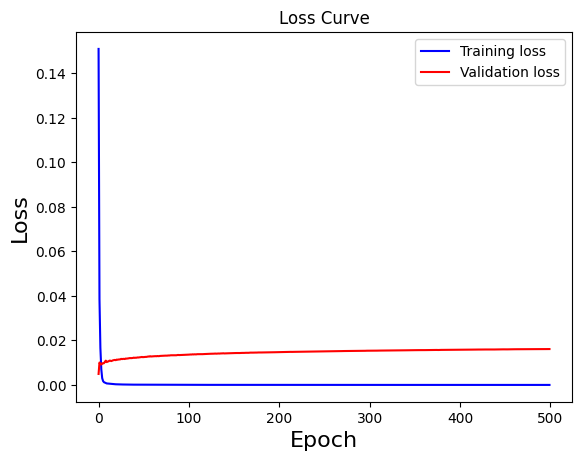

2:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: iteration 34/35
Epoch 0 --- loss:0.003, Validation loss:0.001
Epoch 1: iteration 34/35
Epoch 1 --- loss:0.001, Validation loss:0.000
Epoch 2: iteration 34/35
Epoch 2 --- loss:0.000, Validation loss:0.000
Epoch 3: iteration 34/35
Epoch 3 --- loss:0.000, Validation loss:0.000
Epoch 4: iteration 34/35
Epoch 4 --- loss:0.000, Validation loss:0.000
Epoch 5: iteration 34/35
Epoch 5 --- loss:0.000, Validation loss:0.000
Epoch 6: iteration 34/35
Epoch 6 --- loss:0.000, Validation loss:0.000
Epoch 7: iteration 34/35
Epoch 7 --- loss:0.000, Validation loss:0.000
Epoch 8: iteration 34/35
Epoch 8 --- loss:0.000, Validation loss:0.000
Epoch 9: iteration 34/35
Epoch 9 --- loss:0.000, Validation loss:0.000
Epoch 10: iteration 34/35
Epoch 10 --- loss:0.000, Validation loss:0.000
Epoch 11: iteration 34/35
Epoch 11 --- loss:0.000, Validation loss:0.000
Epoch 12: iteration 34/35
Epoch 12 --- loss:0.000, Validation loss:0.000
Epoch 13: iteration 34/35
Epoch 13 --- loss:0.000, Validation loss:0.00

Epoch 112: iteration 34/35
Epoch 112 --- loss:0.000, Validation loss:0.000
Epoch 113: iteration 34/35
Epoch 113 --- loss:0.000, Validation loss:0.000
Epoch 114: iteration 34/35
Epoch 114 --- loss:0.000, Validation loss:0.000
Epoch 115: iteration 34/35
Epoch 115 --- loss:0.000, Validation loss:0.000
Epoch 116: iteration 34/35
Epoch 116 --- loss:0.000, Validation loss:0.000
Epoch 117: iteration 34/35
Epoch 117 --- loss:0.000, Validation loss:0.000
Epoch 118: iteration 34/35
Epoch 118 --- loss:0.000, Validation loss:0.000
Epoch 119: iteration 34/35
Epoch 119 --- loss:0.000, Validation loss:0.000
Epoch 120: iteration 34/35
Epoch 120 --- loss:0.000, Validation loss:0.000
Epoch 121: iteration 34/35
Epoch 121 --- loss:0.000, Validation loss:0.000
Epoch 122: iteration 34/35
Epoch 122 --- loss:0.000, Validation loss:0.000
Epoch 123: iteration 34/35
Epoch 123 --- loss:0.000, Validation loss:0.000
Epoch 124: iteration 34/35
Epoch 124 --- loss:0.000, Validation loss:0.000
Epoch 125: iteration 34/3

Epoch 221: iteration 34/35
Epoch 221 --- loss:0.000, Validation loss:0.000
Epoch 222: iteration 34/35
Epoch 222 --- loss:0.000, Validation loss:0.000
Epoch 223: iteration 34/35
Epoch 223 --- loss:0.000, Validation loss:0.000
Epoch 224: iteration 34/35
Epoch 224 --- loss:0.000, Validation loss:0.000
Epoch 225: iteration 34/35
Epoch 225 --- loss:0.000, Validation loss:0.000
Epoch 226: iteration 34/35
Epoch 226 --- loss:0.000, Validation loss:0.000
Epoch 227: iteration 34/35
Epoch 227 --- loss:0.000, Validation loss:0.000
Epoch 228: iteration 34/35
Epoch 228 --- loss:0.000, Validation loss:0.000
Epoch 229: iteration 34/35
Epoch 229 --- loss:0.000, Validation loss:0.000
Epoch 230: iteration 34/35
Epoch 230 --- loss:0.000, Validation loss:0.000
Epoch 231: iteration 34/35
Epoch 231 --- loss:0.000, Validation loss:0.000
Epoch 232: iteration 34/35
Epoch 232 --- loss:0.000, Validation loss:0.000
Epoch 233: iteration 34/35
Epoch 233 --- loss:0.000, Validation loss:0.000
Epoch 234: iteration 34/3

Epoch 330: iteration 34/35
Epoch 330 --- loss:0.000, Validation loss:0.000
Epoch 331: iteration 34/35
Epoch 331 --- loss:0.000, Validation loss:0.000
Epoch 332: iteration 34/35
Epoch 332 --- loss:0.000, Validation loss:0.000
Epoch 333: iteration 34/35
Epoch 333 --- loss:0.000, Validation loss:0.000
Epoch 334: iteration 34/35
Epoch 334 --- loss:0.000, Validation loss:0.000
Epoch 335: iteration 34/35
Epoch 335 --- loss:0.000, Validation loss:0.000
Epoch 336: iteration 34/35
Epoch 336 --- loss:0.000, Validation loss:0.000
Epoch 337: iteration 34/35
Epoch 337 --- loss:0.000, Validation loss:0.000
Epoch 338: iteration 34/35
Epoch 338 --- loss:0.000, Validation loss:0.000
Epoch 339: iteration 34/35
Epoch 339 --- loss:0.000, Validation loss:0.000
Epoch 340: iteration 34/35
Epoch 340 --- loss:0.000, Validation loss:0.000
Epoch 341: iteration 34/35
Epoch 341 --- loss:0.000, Validation loss:0.000
Epoch 342: iteration 34/35
Epoch 342 --- loss:0.000, Validation loss:0.000
Epoch 343: iteration 34/3

Epoch 439: iteration 34/35
Epoch 439 --- loss:0.000, Validation loss:0.000
Epoch 440: iteration 34/35
Epoch 440 --- loss:0.000, Validation loss:0.000
Epoch 441: iteration 34/35
Epoch 441 --- loss:0.000, Validation loss:0.000
Epoch 442: iteration 34/35
Epoch 442 --- loss:0.000, Validation loss:0.000
Epoch 443: iteration 34/35
Epoch 443 --- loss:0.000, Validation loss:0.000
Epoch 444: iteration 34/35
Epoch 444 --- loss:0.000, Validation loss:0.000
Epoch 445: iteration 34/35
Epoch 445 --- loss:0.000, Validation loss:0.000
Epoch 446: iteration 34/35
Epoch 446 --- loss:0.000, Validation loss:0.000
Epoch 447: iteration 34/35
Epoch 447 --- loss:0.000, Validation loss:0.000
Epoch 448: iteration 34/35
Epoch 448 --- loss:0.000, Validation loss:0.000
Epoch 449: iteration 34/35
Epoch 449 --- loss:0.000, Validation loss:0.000
Epoch 450: iteration 34/35
Epoch 450 --- loss:0.000, Validation loss:0.000
Epoch 451: iteration 34/35
Epoch 451 --- loss:0.000, Validation loss:0.000
Epoch 452: iteration 34/3

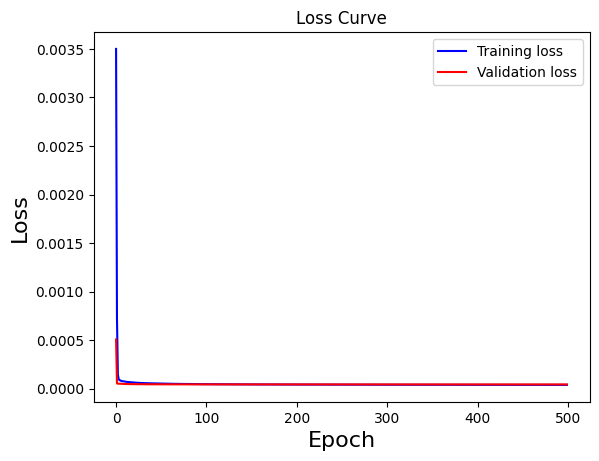

3:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: iteration 34/35
Epoch 0 --- loss:0.000, Validation loss:0.000
Epoch 1: iteration 34/35
Epoch 1 --- loss:0.000, Validation loss:0.000
Epoch 2: iteration 34/35
Epoch 2 --- loss:0.000, Validation loss:0.000
Epoch 3: iteration 34/35
Epoch 3 --- loss:0.000, Validation loss:0.000
Epoch 4: iteration 19/35

KeyboardInterrupt: 

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

train_losses, valid_losses = [], []

print(f'[*] model training - {sub_name}')

fold_path = 'melspectrogram_fold'

for fold in range(5):
    cur_fold_path = os.path.join('melspectrogram_fold', str(fold))
    X_train, y_train, X_test, y_test = get_fold_dataset(cur_fold_path)
    
    pkl_name = f'./model/{data_name}-{sub_name}-{fold}.pkl'
    train_losses, valid_losses = train(model, num_epochs, X_train, y_train, X_test, y_test, pkl_name, fold)
    
    plt.title('Loss Curve')
    plt.ylabel('Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.plot(train_losses[:],'b')
    plt.plot(valid_losses[:],'r')
    plt.legend(['Training loss','Validation loss'])
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

device = torch.device('cpu')
model = model.to(device)

test_accs = []

for fold in range(5):
    pkl_name = f'./model/{data_name}-{sub_name}-{fold}.pkl'
    
    load_checkpoint(optimizer, model, pkl_name)
    
    validate = make_validate_fnc(model, criterion)
    
    cur_fold_path = os.path.join('melspectrogram_fold', str(fold))
    X_train, y_train, X_test, y_test = get_fold_dataset(cur_fold_path)
    
    X_test_tensor = torch.tensor(X_test).float()
    X_test_tensor = X_test_tensor.permute(0, 3, 1, 2)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    
    test_loss, test_acc, predicted_emotions = validate(X_test_tensor, y_test_tensor)
    print(f'[*] {fold} Test accuracy is {test_acc:.2f}%')
    test_accs.append(test_acc)
    
    predicted_emotions = predicted_emotions.cpu().numpy()
    # use labels from test set
    emotions_groundtruth = y_test_tensor

    # build confusion matrix and normalized confusion matrix
    conf_matrix = confusion_matrix(emotions_groundtruth, predicted_emotions)
    conf_matrix_norm = confusion_matrix(emotions_groundtruth, predicted_emotions,normalize='true')

    # set labels for matrix axes from emotions
    emotion_names = [emotion for emotion in emotions_dict.values()]

    # make a confusion matrix with labels using a DataFrame
    confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_names, columns=emotion_names)
    confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_names, columns=emotion_names)

    # plot confusion matrices
    plt.figure(figsize=(16,6))
    sn.set(font_scale=1.8) # emotion label and title size
    plt.subplot(1,2,1)
    plt.title('Confusion Matrix')
    sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
    plt.subplot(1,2,2)
    plt.title('Normalized Confusion Matrix')
    sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

    plt.show()

In [ ]:
def Average(lst):
    return sum(lst) / len(lst)

print('[*] K-Fold training done !')
print(f'[*] Best fold acc : {max(test_accs):.2f}%')
print(f'[*] Worst fold acc : {min(test_accs):.2f}%')
print(f'[*] Average fold acc : {Average(test_accs):.2f}%')

In [ ]:
from sklearn.metrics import classification_report

device = torch.device('cpu')
model = model.to(device)

test_accs = []

for fold in range(5):
    pkl_name = f'./model/{data_name}-{sub_name}-{fold}.pkl'
    
    load_checkpoint(optimizer, model, pkl_name)
    
    validate = make_validate_fnc(model, criterion)
    
    cur = all_fold_dataset[fold]
    
    X_test_tensor = torch.tensor(cur[2]).float()
    X_test_tensor = X_test_tensor.permute(0, 3, 1, 2)
    y_test_tensor = torch.tensor(cur[3], dtype=torch.long)
    
    test_loss, test_acc, predicted_emotions = validate(X_test_tensor, y_test_tensor)
    print(f'[*] {fold} Test accuracy is {test_acc:.2f}%')
    test_accs.append(test_acc)
    
    predicted_emotions = predicted_emotions.cpu().numpy()
    # use labels from test set
    emotions_groundtruth = y_test_tensor

    print(classification_report(emotions_groundtruth, predicted_emotions))